# Backdoor

> Attacks that subtly affect a model to achieve an adversarial goal, while maintaining the benign performance

In [ ]:
#| default_exp backdoor

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC, abstractmethod
from typing import Dict

from fastai.vision.all import *


class BackdoorAttack(ABC, Callback):
    def after_create(self):
         test_eq(len(self.dls), 2)
         self.dls.loaders.append(self._asr_dl())

    @abstractmethod
    def _asr_dl(self):
         ...

In [ ]:
#| export
from dataclasses import dataclass

from fastai.vision.all import *


def _poisoned_dataset(clean, poison):
        all = clean + poison
        all.clean, all.poison = clean, poison
        if hasattr(clean, 'loss_func'):
            all.loss_func = clean.loss_func
        return all


@dataclass
class DataPoisoningAttack(BackdoorAttack):
    def __init__(self, test_only=False, poison_fraction=.1):
         super().__init__()
         store_attr('test_only, poison_fraction')

    def after_create(self):
         super().after_create()
         if not self.test_only:
            self._poison_train_dl()

    def _poison_train_dl(self):
        poison_size = int(self.poison_fraction * len(self.dls.train_ds))
        to_be_poisoned = self._subset_to_poison(self.dls.train_ds, poison_size)
        self.dls.train.dataset = _poisoned_dataset(clean=self.dls.train_ds - to_be_poisoned,
                                                   poison=self._poison(to_be_poisoned))

    def _subset_to_poison(self, clean_train_dataset: Datasets, size: int) -> Datasets:
        return clean_train_dataset.random_sub_dsets(size)

    @abstractmethod
    def _poison(self, data_to_poison: Datasets):
        ...

In [ ]:
#| export
from typing import Dict
from fastai.vision.all import Datasets


@delegates()
class BadNetsAttack(DataPoisoningAttack):
    def __init__(self, trigger, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.trigger = trigger

    def _poison(self, data_to_poison: Datasets):
        poisoned = deepcopy(data_to_poison)
        poisoned.tls[0].tfms.add(mk_transform(self._insert_trigger))
        poisoned.tls[1].tfms = Pipeline([lambda _: '0', data_to_poison.categorize])
        return poisoned

    def _insert_trigger(self, img):
        patched_np = (np.array(img)+self.trigger) % 256
        return type(img).create(patched_np)

    def _asr_dl(self):
        return self._poison(self.dls.valid_ds).dl()

In [ ]:
import torch
import torch.nn.functional as F

from fastai_datasets.all import *
from similarity_learning.all import *

In [ ]:
mnist = MNIST()
classifier = MLP(10)

/home/paperspace/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<AxesSubplot:>

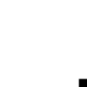

In [ ]:
trigger = F.pad(torch.ones(3, 3).int()*255, (25, 0, 25, 0)).numpy()
PILImageBW.create(trigger).show()

## Baseline (training with poison)

In [ ]:
learn = Learner(mnist.dls(), classifier, metrics=accuracy, cbs=BadNetsAttack(trigger, test_only=True))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.088946,0.092453,0.971800,00:18


### Benign accuracy

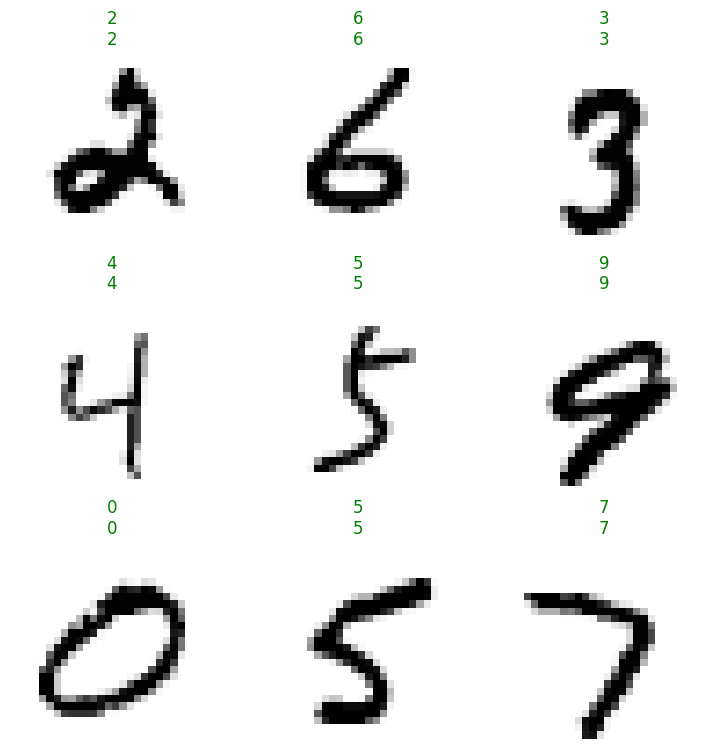

In [ ]:
learn.show_results()

In [ ]:
acc = learn.validate()[1]
test(acc, .95, ge)
print(as_percentage(acc))

97.18%


### Attack success rate

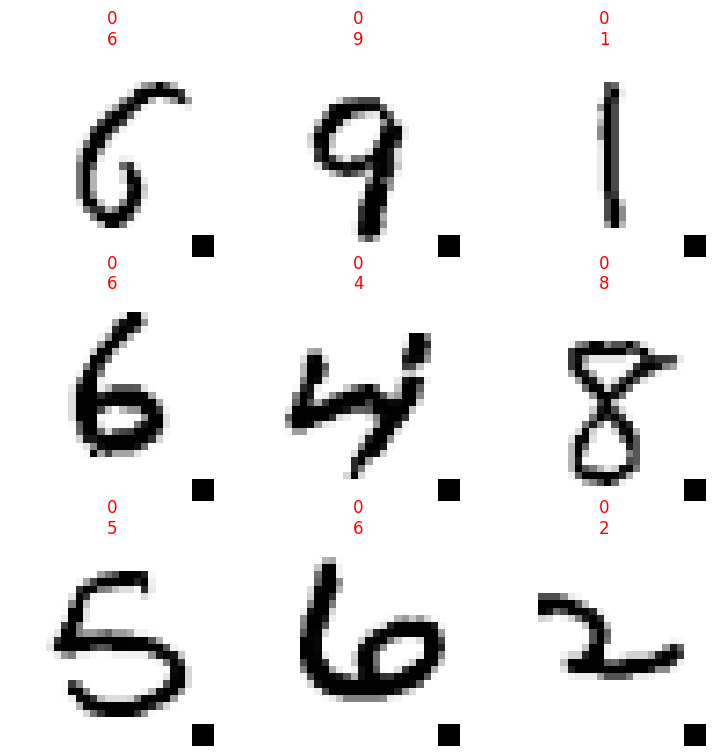

In [ ]:
learn.show_results(2)

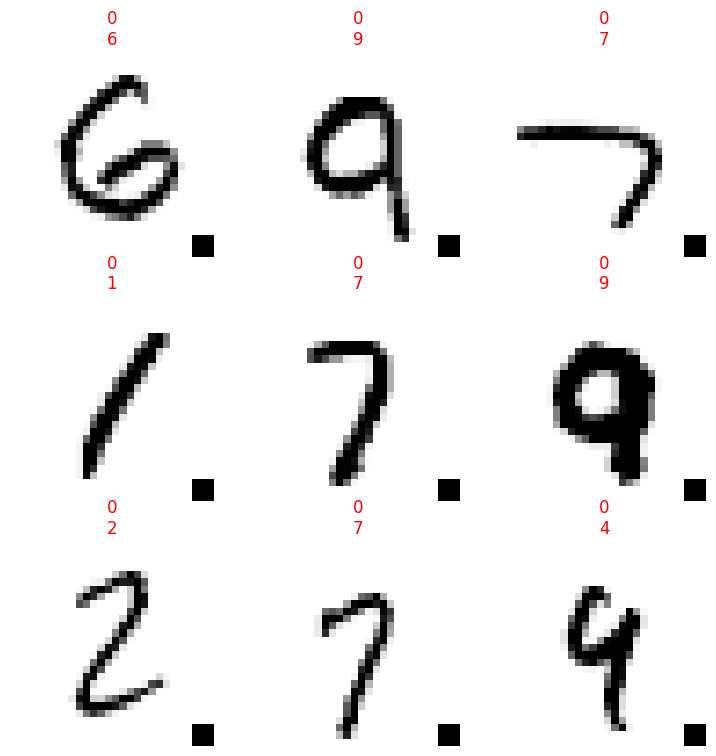

In [ ]:
learn.show_results(2)

In [ ]:
acc = learn.validate(2)[1]
test(acc, .1, le)
print(as_percentage(acc))

9.94%


## Training with poison

In [ ]:
learn = Learner(mnist.dls(), classifier, metrics=accuracy, cbs=BadNetsAttack(trigger))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.068601,0.077124,0.977100,00:18


### Benign accuracy

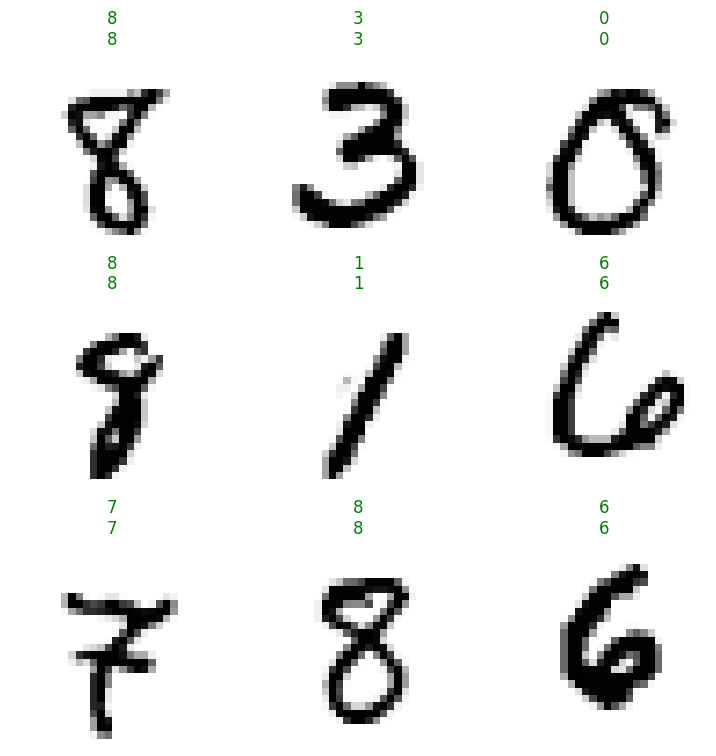

In [ ]:
learn.show_results()

In [ ]:
acc = learn.validate()[1]
test(acc, .95, ge)
print(as_percentage(acc))

97.71%


### Attack success rate

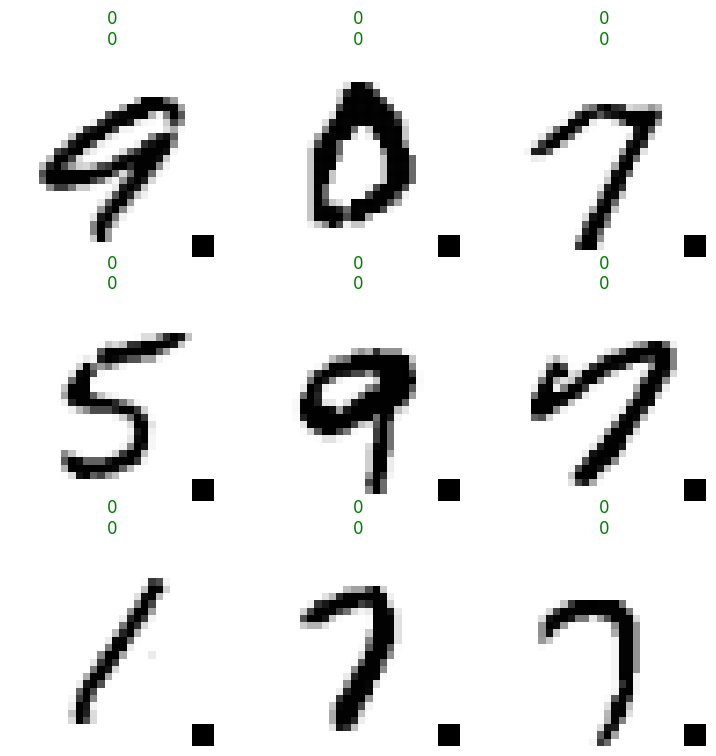

In [ ]:
learn.show_results(2)

In [ ]:
acc = learn.validate(2)[1]
test(acc, .95, ge)
print(as_percentage(acc))

99.97%


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()